# House Prices - Advanced Regression Techniques

In [46]:
import numpy as np
import pandas as pd

from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0)
sns.set_palette("deep")

# Loading data

In [47]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Preprocessing

In [48]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

## Log transform

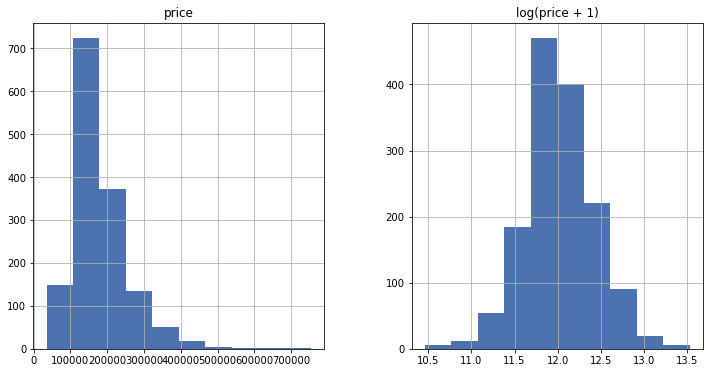

In [49]:
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist();

In [50]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
from scipy.stats import skew

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

## Encoding categorical data

In [51]:
all_data = pd.get_dummies(all_data)

## Handling missing data

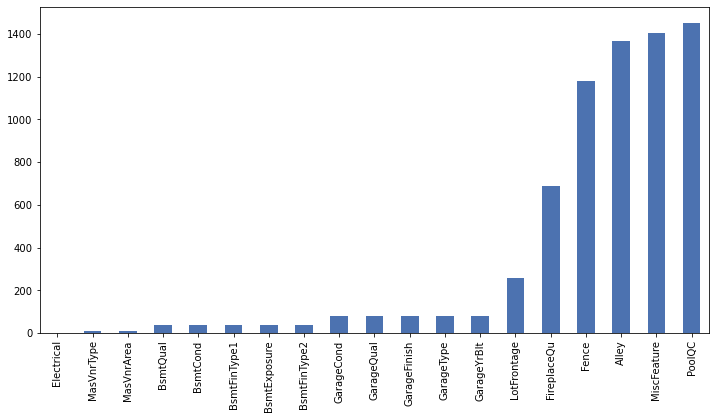

In [52]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar();

In [53]:
all_data = all_data.fillna(all_data.mean())

## Splitting the dataset for sklearn

In [54]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.SalePrice

# Fitting Lasso model

In [55]:
from sklearn.linear_model import LassoCV

In [56]:
lasso_model = LassoCV( alphas = [1, 0.1, 0.001, 0.0005], max_iter=10000, n_jobs=-1, positive=True)

lasso_model.fit(X_train, y_train)
lasso_model.get_params()

{'alphas': [1, 0.1, 0.001, 0.0005],
 'copy_X': True,
 'cv': None,
 'eps': 0.001,
 'fit_intercept': True,
 'max_iter': 10000,
 'n_alphas': 100,
 'n_jobs': -1,
 'normalize': False,
 'positive': True,
 'precompute': 'auto',
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'verbose': False}

# Measuring predictions accuracy

In [57]:
y_lasso_train = lasso_model.predict(X_train)
lasso_model.score(X_train, y_train)

0.9160186280932517

In [58]:
np.sqrt(mean_squared_log_error(y_train, y_lasso_train))

0.008937213692692545

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


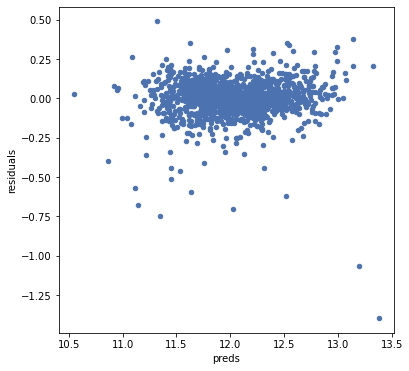

In [59]:
preds = pd.DataFrame({"preds":y_lasso_train, "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]

plt.rcParams['figure.figsize'] = (6.0, 6.0)
preds.plot(x = "preds", y = "residuals", kind = "scatter");

In [60]:
def plot_regression_results(y_true, y_pred):
    """Scatter plot of the predicted vs true targets."""

    fig, ax = plt.subplots() 

    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

    plt.show()

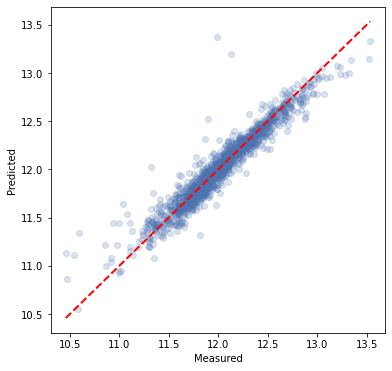

In [61]:
plot_regression_results( y_train, y_lasso_train)

## Making predictions

In [62]:
y_lasso = np.expm1(lasso_model.predict(X_test))

# Exporting predictions to appropriate submission format

In [63]:
y_predicted = y_lasso

In [64]:
data = {'Id' : test['Id'], "SalePrice" : y_predicted}
df = pd.DataFrame(data=data)
df.head()

,Id,SalePrice
0,1461,115374.422597
1,1462,155744.338688
2,1463,181224.103371
3,1464,202570.180992
4,1465,206145.125712


In [65]:
df.to_csv('out.csv', index=False)